# 2024-026 Differential Peak Analysis

This notebook describes steps to perform differential peak analysis of ATAC-seq data.

## Initialize Enviroment

In [1]:
# Load Libraries
library(DESeq2)
library(ggplot2)
library(dplyr)
library(tidyr)

# Load data
exp_dir     <- "/home/dalbao/2024-026-Tcf7ATAC"
nfcore_dir  <- "01_nfcore_241228"
nb_dir      <- "02_bp_notebooks"
prefix      <- "DA-DAPS_interaction"                                   # bp for broad peak calling settings

# Experiments to analyze
exp <- c("DA")

# Comparisons
comp_file <- "metadata/comparisons_da_naive.csv"

# Annotations
anno_file <- "250113-bp-peakAnno-Filtered.csv"
# Add folder structure to anno_file
anno_file <- paste(nfcore_dir, anno_file, sep = "/")

# Filter file
filter_file <- "241231-bp-peakFilter.txt"
# Add folder structure to filter_file
filter_file <- paste(nfcore_dir, filter_file, sep = "/")

# nf-core ATAC-seq pipeline calls peaks from two different libraries:
library     <- "merged_library"
# If library == merged_library, lib_sh is mLb
# else if it is == merged_replicates, lib_sh is mRp
lib_sh      <- ifelse(library == "merged_library", "mLb", "mRp")

# nf-core ATAC-seq pipeline calls peaks in two types, broad_peak and narrow_peak:
peak_type   <- "broad_peak"
# If peak_type == broad_peak, peak_sh is bp
peak_sh     <- ifelse(peak_type == "broad_peak", "bp", "np")

# Add peak type and date to prefix
prefix <- paste0(format(Sys.Date(), "%y%m%d"), "-", peak_sh, "-", prefix)

# Move to working directory
setwd(exp_dir)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, saveRDS, setdiff,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomicRanges

Loading required package: GenomeInfoDb



In [ ]:
# Find featre counts file
featureCounts <- paste( nfcore_dir,
                        "/bwa/",
                        library,
                        "/macs2/",
                        peak_type,
                        "/consensus/",
                        "consensus_peaks.", lib_sh, ".clN.featureCounts.txt", sep = "")

# Load feature counts
featureCounts <- read.table(featureCounts,
                            header = TRUE)

# Remove unnecessary columns
featureCounts <- featureCounts[, -c(2:6)]

# Rename columns
sample_suffix <- paste0(".", lib_sh, ".clN.sorted.bam")
colnames(featureCounts) <- gsub(sample_suffix, "", colnames(featureCounts))

# Make intervals as row names
rownames(featureCounts) <- featureCounts$Geneid
featureCounts <- featureCounts[, -1]

# Check
head(featureCounts)

,DW_WT_24h_REP2,DW_RUNX3KO_0h_REP2,DW_WT_12h_REP2,Tcm_WT_REP1,DW_RUNX3KO_2h_REP2,DW_RUNX3KO_6h_REP2,Effector_REP2,DW_RUNX3KO_6h_REP1,DW_RUNX3KO_0h_REP1,DW_WT_0h_REP1,⋯,GFPneg_d28_REP3,GFPneg_d28_REP1,GFPpos_d8_REP1,GFPneg_d8_REP3,GFPpos_d8_REP2,GFPneg_d8_REP2,GFPneg_d28_REP2,GFPpos_d28_REP1,GFPneg_d8_REP1,DW_WT_6h_REP2
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
Interval_1,2,0,2,0,2,1,2,0,2,1,⋯,5,4,5,4,6,3,2,4,7,7
Interval_2,2,1,10,0,0,2,2,1,2,3,⋯,8,2,5,6,10,7,9,5,7,15
Interval_3,1,1,1,0,3,1,1,0,1,2,⋯,3,2,2,2,2,1,2,5,3,5
Interval_4,1,1,2,0,0,0,0,0,0,0,⋯,4,1,4,1,3,4,1,8,0,3
Interval_5,2,1,0,0,1,2,0,0,0,1,⋯,5,4,5,4,6,1,6,7,6,6
Interval_6,3,3,1,0,1,1,0,0,5,2,⋯,10,2,2,5,0,4,3,8,5,8


In [ ]:
observedPeaks <- read.csv(  "observedPeaks75.csv",
                            header = TRUE,
                            row.names = 1)

observedPeaks <- observedPeaks %>%
    filter(DA)
head(observedPeaks)

,DA,DPF,DW,JSB,OK,ST,XZ
,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
Interval_98,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE
Interval_103,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE
Interval_105,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,FALSE
Interval_107,TRUE,TRUE,FALSE,TRUE,FALSE,FALSE,FALSE
Interval_108,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE
Interval_110,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE


In [3]:
# Load sample metadata
sampleMetadata <- read.csv("metadata/sampleMetadata.csv")

# Make sample names as row names
rownames(sampleMetadata) <- sampleMetadata$Sample
sampleMetadata <- sampleMetadata[, -1]

# Check
head(sampleMetadata)

# Make sure the observations in sampleMetadata are in the same order as the columns in featureCounts
sampleMetadata <- sampleMetadata[colnames(featureCounts), ]

# Load keep peaks file
keep <- read.table(filter_file, header = TRUE)
keep <- keep[keep$keep == TRUE, ]

# Keep only features (identified by rowname) that are in keep$interval_id
featureCounts <- featureCounts[rownames(featureCounts) %in% keep$interval_id, ]
head(featureCounts)

,Experiment,Condition,Phenotype,Transduction,Rep,DW_time,DW_genotype,Time,Genotype,Batch
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<chr>,<chr>
DW_WT_24h_REP2,DW,DW_WT_24h,,,REP2,24,WT,NA,,
DW_RUNX3KO_0h_REP2,DW,DW_RUNX3KO_0h,,,REP2,0,RUNX3KO,NA,,
DW_RUNX3KO_6h_REP1,DW,DW_RUNX3KO_6h,,,REP1,6,RUNX3KO,NA,,
DW_WT_6h_REP1,DW,DW_WT_6h,,,REP1,6,WT,NA,,
CX3CR1pos_shRunx3_REP2,DA,CX3CR1pos_shRunx3,CX3CR1pos,shRunx3,,NA,,NA,,B
DW_WT_0h_REP1,DW,DW_WT_0h,,,REP1,0,WT,NA,,


,DW_WT_24h_REP2,DW_RUNX3KO_0h_REP2,DW_WT_12h_REP2,Tcm_WT_REP1,DW_RUNX3KO_2h_REP2,DW_RUNX3KO_6h_REP2,Effector_REP2,DW_RUNX3KO_6h_REP1,DW_RUNX3KO_0h_REP1,DW_WT_0h_REP1,⋯,GFPneg_d28_REP3,GFPneg_d28_REP1,GFPpos_d8_REP1,GFPneg_d8_REP3,GFPpos_d8_REP2,GFPneg_d8_REP2,GFPneg_d28_REP2,GFPpos_d28_REP1,GFPneg_d8_REP1,DW_WT_6h_REP2
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
Interval_98,17,32,33,35,12,14,80,3,27,61,⋯,234,224,212,147,176,165,240,364,177,128
Interval_103,29,5,28,22,8,9,51,1,3,13,⋯,183,160,117,172,132,179,242,157,216,66
Interval_105,22,37,23,5,33,47,27,9,29,20,⋯,146,133,81,66,80,97,139,117,95,165
Interval_107,12,12,11,4,15,18,26,6,16,19,⋯,82,73,61,49,59,56,86,73,80,131
Interval_108,108,224,160,110,222,194,174,39,247,244,⋯,858,707,482,449,536,594,751,676,531,975
Interval_110,172,210,274,158,274,271,158,57,264,252,⋯,942,771,527,495,480,648,909,740,633,1388


## Perform Naive Analysis

In [ ]:
# DA experiment is tagged as DA in sampleMetadata
daMeta <- sampleMetadata[sampleMetadata$Experiment %in% exp, ]
daExp  <- featureCounts[, colnames(featureCounts) %in% rownames(daMeta), ]

# Check one-to-one correspondence
all(rownames(daMeta) == colnames(daExp))

# Check
head(daMeta)
head(daExp)

Create the DESeq2 object:

In [ ]:
# Create DESeq object
dds <- DESeqDataSetFromMatrix(  countData = daExp,
                                colData   = daMeta,
                                design    = ~ Condition)

# Process DESeq
dds <- DESeq(dds)

# Plot PCA
vst_data <- vst(dds, blind = TRUE)
plotPCA(vst_data, intgroup = c("Condition"))
plotPCA(vst_data, intgroup = c("Batch"))

### Comparisons

In [ ]:
# Load comparisons CSV
comparisons <- read.csv(comp_file)

# Initialize an empty list to store results dataframes
results <- list()

# Loop over each row in the comparisons dataframe to perform differential expression analysis
for ( i in 1:nrow(comparisons) ) {
  # Perform differential expression analysis using DESeq2 (or similar) for the current comparison
  # The contrast is set using the 'Condition' column, comparing the numerator vs the denominator
  # res <- lfcShrink( dds,
  #                   contrast = c("Condition", comparisons$Numerator[i], comparisons$Denominator[i]),
  #                   type = "ashr")
  # The contrast is set using the 'sample' column, comparing the numerator vs the denominator
  stat <- results(dds, contrast = c("Condition", comparisons$Numerator[i], comparisons$Denominator[i]))

  # Create a dataframe from the results object for the current comparison
  # Include comparison identifiers, statistical results, and gene names
  results[[comparisons$Comparison[i]]] <- data.frame(
    comparison = comparisons$Comparison[i],
    numerator = comparisons$Numerator[i],
    denominator = comparisons$Denominator[i],
    name = rownames(stat),
    baseMean = stat$baseMean,
    log2FC = stat$log2FoldChange,
    statistic = stat$stat,
    pvalue = stat$pvalue,
    padj = stat$padj
  )

  # Remove rows with any missing values to ensure clean data
  results[[comparisons$Comparison[i]]] <- results[[comparisons$Comparison[i]]][complete.cases(results[[comparisons$Comparison[i]]]), ]
  # Order the results by the statistic in decreasing order for prioritization
  results[[comparisons$Comparison[i]]] <- results[[comparisons$Comparison[i]]][order(results[[comparisons$Comparison[i]]]$statistic, decreasing = TRUE), ]

  # Cleanup: Remove temporary variables to free memory (though removing 'i' is not necessary)
  rm(stat, i)
}

# Combine all individual comparison result dataframes into a single dataframe
results_naive <- bind_rows(results)

# View
head(results_naive)

## Perform Batch-Corrected Individual Comparisons

In [ ]:
# DA experiment is tagged as DA in sampleMetadata
daMeta <- sampleMetadata[sampleMetadata$Condition != "naive" & sampleMetadata$Experiment == exp[1], ]
daExp  <- featureCounts[, colnames(featureCounts) %in% rownames(daMeta), ]

# Check one-to-one correspondence
all(rownames(daMeta) == colnames(daExp))

# Check
head(daMeta)
head(daExp)

# Create DESeq object
dds <- DESeqDataSetFromMatrix(countData = daExp,
                              colData   = daMeta,
                              design    = ~ Condition + Batch)

# Process DESeq
dds <- DESeq(dds)

# Plot PCA
vst_data <- vst(dds, blind = TRUE)
plotPCA(vst_data, intgroup = c("Condition"))
plotPCA(vst_data, intgroup = c("Batch"))

# Load comparisons CSV
comparisons <- read.csv("metadata/comparisons_da.csv")

head(comparisons)

# Initialize an empty list to store results dataframes
results <- list()

# Loop over each row in the comparisons dataframe to perform differential expression analysis
for ( i in 1:nrow(comparisons) ) {
  # Perform differential expression analysis using DESeq2 (or similar) for the current comparison
  # The contrast is set using the 'Condition' column, comparing the numerator vs the denominator
  # res <- lfcShrink( dds,
  #                   contrast = c(comparisons$Coefficient[i], comparisons$Numerator[i], comparisons$Denominator[i]),
  #                   type = "ashr")
  # The contrast is set using the 'sample' column, comparing the numerator vs the denominator
  stat <- results(dds, contrast = c("Condition", comparisons$Numerator[i], comparisons$Denominator[i]))

  # Create a dataframe from the results object for the current comparison
  # Include comparison identifiers, statistical results, and gene names
  results[[comparisons$Comparison[i]]] <- data.frame(
    comparison = comparisons$Comparison[i],
    numerator = comparisons$Numerator[i],
    denominator = comparisons$Denominator[i],
    name = rownames(stat),
    baseMean = stat$baseMean,
    log2FC = stat$log2FoldChange,
    statistic = stat$stat,
    pvalue = stat$pvalue,
    padj = stat$padj
  )

  # Remove rows with any missing values to ensure clean data
  results[[comparisons$Comparison[i]]] <- results[[comparisons$Comparison[i]]][complete.cases(results[[comparisons$Comparison[i]]]), ]
  # Order the results by the statistic in decreasing order for prioritization
  results[[comparisons$Comparison[i]]] <- results[[comparisons$Comparison[i]]][order(results[[comparisons$Comparison[i]]]$statistic, decreasing = TRUE), ]

  # Cleanup: Remove temporary variables to free memory (though removing 'i' is not necessary)
  rm(stat, i)
}

# Combine all individual comparison result dataframes into a single dataframe
results_individual <- bind_rows(results)

# View
head(results_individual)

## Perform Batch-Corrected Combined Comparisons

[1] TRUE

,Experiment,Condition,Phenotype,Transduction,Rep,DW_time,DW_genotype,Time,Genotype,Batch
,<chr>,<chr>,<fct>,<fct>,<chr>,<int>,<chr>,<int>,<chr>,<chr>
CX3CR1pos_shCD19_REP2,DA,CX3CR1pos_shCD19,CX3CR1pos,shCD19,,NA,,NA,,B
CX3CR1pos_shRunx3_REP2,DA,CX3CR1pos_shRunx3,CX3CR1pos,shRunx3,,NA,,NA,,B
GFPpos_shCD19_REP2,DA,GFPpos_shCD19,GFPpos,shCD19,,NA,,NA,,B
CX3CR1pos_shRunx3_REP1,DA,CX3CR1pos_shRunx3,CX3CR1pos,shRunx3,,NA,,NA,,A
GFPneg_shCD19_REP1,DA,GFPneg_shCD19,GFPneg,shCD19,,NA,,NA,,A
GFPpos_shCD19_REP1,DA,GFPpos_shCD19,GFPpos,shCD19,,NA,,NA,,A


,CX3CR1pos_shCD19_REP2,CX3CR1pos_shRunx3_REP2,GFPpos_shCD19_REP2,CX3CR1pos_shRunx3_REP1,GFPneg_shCD19_REP1,GFPpos_shCD19_REP1,GFPpos_shRunx3_REP1,GFPneg_shRunx3_REP2,GFPneg_shRunx3_REP1,GFPneg_shCD19_REP2,CX3CR1pos_shCD19_REP1,GFPpos_shRunx3_REP2
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
Interval_98,76,39,54,64,51,34,32,66,44,95,57,98
Interval_103,77,26,28,89,24,39,28,31,34,59,77,41
Interval_105,45,8,21,57,21,33,21,29,19,36,41,37
Interval_107,42,8,25,46,16,34,24,25,25,42,36,51
Interval_108,374,160,421,531,470,538,478,349,466,565,550,531
Interval_110,317,119,355,417,335,409,307,284,351,426,360,412


Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

using ntop=500 top features by variance

using ntop=500 top features by variance



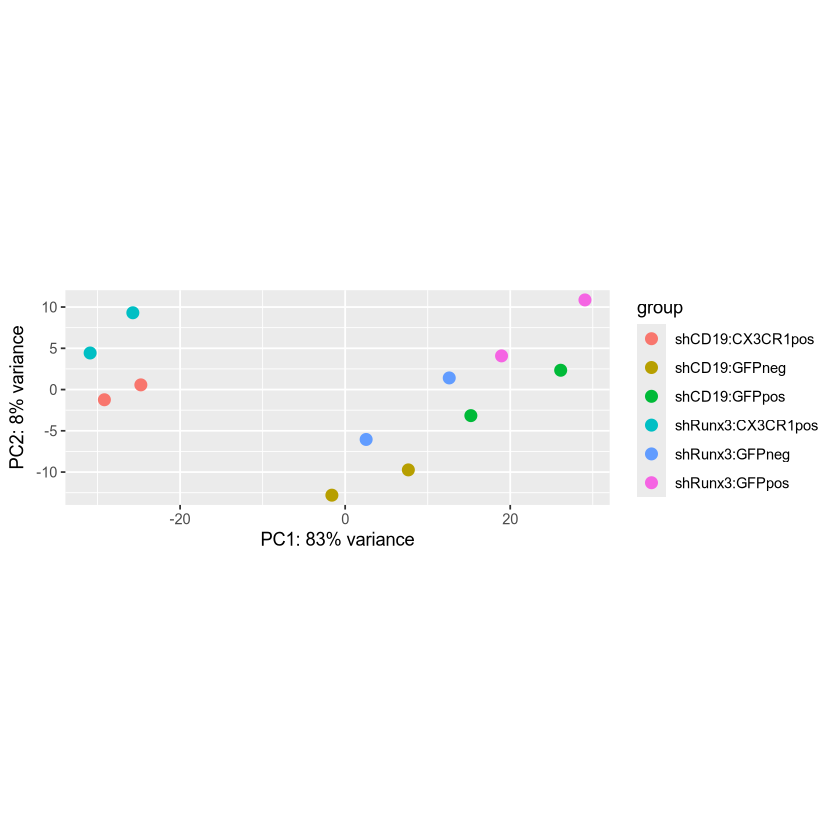

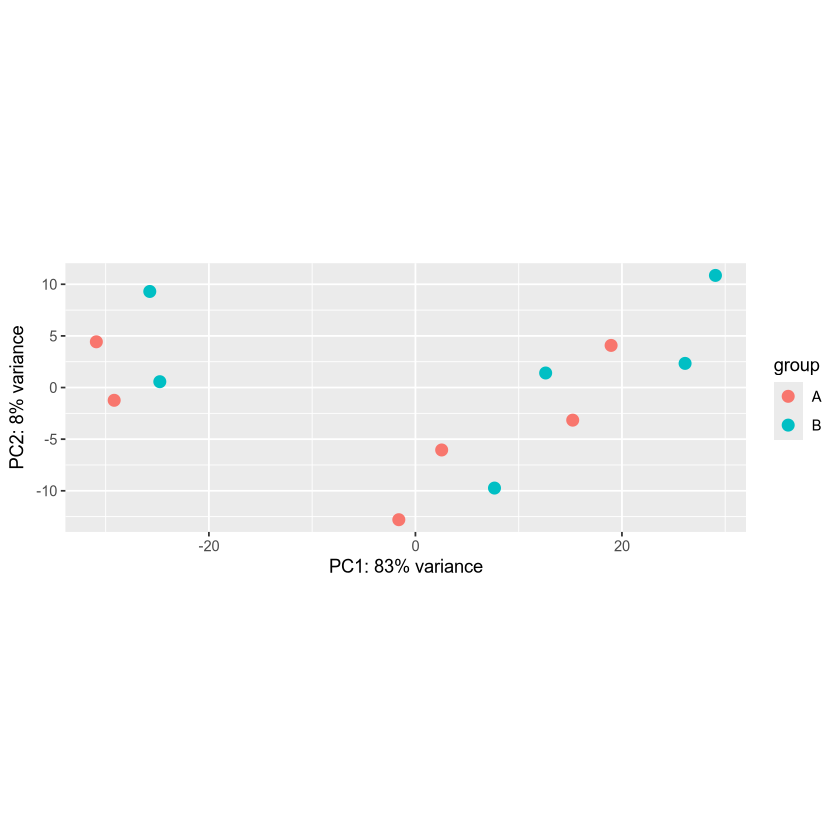

In [87]:
# DA experiment is tagged as DA in sampleMetadata
daMeta <- sampleMetadata[sampleMetadata$Condition != "naive" & sampleMetadata$Experiment == exp[1], ]
daExp  <- featureCounts[rownames(featureCounts) %in% rownames(observedPeaks),
                        colnames(featureCounts) %in% rownames(daMeta)]

# Check one-to-one correspondence
all(rownames(daMeta) == colnames(daExp))

daMeta$Transduction <- factor(  daMeta$Transduction,
                                levels = c("shCD19", "shRunx3"))
daMeta$Phenotype <- factor( daMeta$Phenotype,
                            levels = c("GFPpos", "GFPneg", "CX3CR1pos"))

# Check
head(daMeta)
head(daExp)

# Relevel


# Create DESeq object
dds <- DESeqDataSetFromMatrix(  countData = daExp,
                                colData   = daMeta,
                                design    = ~ Transduction + Phenotype + Transduction:Phenotype + Batch)

# Process DESeq
dds <- estimateSizeFactors(dds)
dds <- estimateDispersions(dds)
dds <- nbinomLRT(dds, reduced = ~ Transduction + Phenotype + Batch)

# Plot PCA
vst_data <- vst(dds, blind = TRUE)
plotPCA(vst_data, intgroup = c("Transduction", "Phenotype"))
plotPCA(vst_data, intgroup = c("Batch"))


In [75]:
resultsNames(dds)

[1] "Intercept"                           "Transduction_shRunx3_vs_shCD19"     
[3] "Phenotype_GFPneg_vs_GFPpos"          "Batch_B_vs_A"                       
[5] "TransductionshRunx3.PhenotypeGFPneg"

In [90]:
results <- results(dds, contrast = list(
  c(    "Transduction_shRunx3_vs_shCD19"
)))
results$BH <- p.adjust(results$pvalue, method = "BH")

In [91]:
results["Interval_185628",]

log2 fold change (MLE): Transduction_shRunx3_vs_shCD19 effect 
LRT p-value: '~ Transduction + Phenotype + Transduction:Phenotype + Batch' vs '~ Transduction + Phenotype + Batch' 
DataFrame with 1 row and 7 columns
                 baseMean log2FoldChange     lfcSE      stat    pvalue
                <numeric>      <numeric> <numeric> <numeric> <numeric>
Interval_185628   133.244       0.545011  0.230772   1.88863  0.388946
                     padj        BH
                <numeric> <numeric>
Interval_185628  0.970972  0.999992

In [54]:
daExp["Interval_185628",]

,CX3CR1pos_shCD19_REP2,CX3CR1pos_shRunx3_REP2,GFPpos_shCD19_REP2,CX3CR1pos_shRunx3_REP1,GFPneg_shCD19_REP1,GFPpos_shCD19_REP1,GFPpos_shRunx3_REP1,GFPneg_shRunx3_REP2,GFPneg_shRunx3_REP1,GFPneg_shCD19_REP2,CX3CR1pos_shCD19_REP1,GFPpos_shRunx3_REP2
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
Interval_185628,45,16,183,72,144,237,301,133,146,88,74,371


In [80]:
?results

results                 package:DESeq2                 R Documentation

_E_x_t_r_a_c_t _r_e_s_u_l_t_s _f_r_o_m _a _D_E_S_e_q _a_n_a_l_y_s_i_s

_D_e_s_c_r_i_p_t_i_o_n:

     ‘results’ extracts a result table from a DESeq analysis giving
     base means across samples, log2 fold changes, standard errors,
     test statistics, p-values and adjusted p-values; ‘resultsNames’
     returns the names of the estimated effects (coefficents) of the
     model; ‘removeResults’ returns a ‘DESeqDataSet’ object with
     results columns removed.

_U_s_a_g_e:

     results(
       object,
       contrast,
       name,
       lfcThreshold = 0,
       altHypothesis = c("greaterAbs", "lessAbs", "greater", "less", "greaterAbs2014"),
       listValues = c(1, -1),
       cooksCutoff,
       independentFiltering = TRUE,
       alpha = 0.1,
       filter,
       theta,
       pAdjustMethod = "BH",
       filterFun,
       format = c("DataFrame", "GRanges", "GRan

In [ ]:

# Load comparisons CSV
comparisons <- read.csv("metadata/comparisons_da_combined.csv")

head(comparisons)

# Initialize an empty list to store results dataframes
results <- list()

# Loop over each row in the comparisons dataframe to perform differential expression analysis
for ( i in 1:nrow(comparisons) ) {
  # Perform differential expression analysis using DESeq2 (or similar) for the current comparison
  # The contrast is set using the 'Condition' column, comparing the numerator vs the denominator
  # res <- lfcShrink( dds,
  #                   contrast = c(comparisons$Coefficient[i], comparisons$Numerator[i], comparisons$Denominator[i]),
  #                   type = "ashr")
  # The contrast is set using the 'sample' column, comparing the numerator vs the denominator
  stat <- results(dds, contrast = c(comparisons$Coefficient[i], comparisons$Numerator[i], comparisons$Denominator[i]))

  # Create a dataframe from the results object for the current comparison
  # Include comparison identifiers, statistical results, and gene names
  results[[comparisons$Comparison[i]]] <- data.frame(
    comparison = comparisons$Comparison[i],
    numerator = comparisons$Numerator[i],
    denominator = comparisons$Denominator[i],
    name = rownames(stat),
    baseMean = stat$baseMean,
    log2FC = stat$log2FoldChange,
    statistic = stat$stat,
    pvalue = stat$pvalue,
    padj = stat$padj
  )

  # Remove rows with any missing values to ensure clean data
  results[[comparisons$Comparison[i]]] <- results[[comparisons$Comparison[i]]][complete.cases(results[[comparisons$Comparison[i]]]), ]
  # Order the results by the statistic in decreasing order for prioritization
  results[[comparisons$Comparison[i]]] <- results[[comparisons$Comparison[i]]][order(results[[comparisons$Comparison[i]]]$statistic, decreasing = TRUE), ]

  # Cleanup: Remove temporary variables to free memory (though removing 'i' is not necessary)
  rm(stat, i)
}

# Combine all individual comparison result dataframes into a single dataframe
results_combined <- bind_rows(results)

# View
head(results_combined)

results <- rbind.data.frame(results_naive, results_individual, results_combined)

In [ ]:
# Write the combined results dataframe to a CSV file without row names
fn <- paste0(prefix, "-Unannotated.csv")
fn <- paste0(nb_dir, "/daps/", fn)
write.csv(results, file = fn, row.names = FALSE)

## Count Differential Peaks

### p < 0.1

In [ ]:
signif_counts <- function(results, padj_threshold = 0.1) {
    # Filter results for significant genes (padj < 0.1) and save into a new dataframe called "signif"
    signif <- results[results$padj < padj_threshold, ]

    # Create a new column named "direction" in signif and
    # assign "up" if log2FC > 0, "down" if log2FC < 0, and "no change" if log2FC = 0
    signif$direction <- ifelse(signif$log2FC > 0, "up", ifelse(signif$log2FC < 0, "down", "no change"))

    # Count the number of up and down peaks for each comparison in signif
    # Then spread the data to have separate columns for up and down counts
    counts <- signif %>%
    group_by(comparison, direction) %>%
    summarise(count = n()) %>%
    spread(direction, count)

    counts
}

signif_counts(results, padj_threshold = 0.1)

### p < 0.05

In [ ]:
signif_counts(results, padj_threshold = 0.05)

## Annotation

In [ ]:
# Import gene annotation without altering existing column names
gene_annot <- read.csv( anno_file,
                        header = TRUE)
head(gene_annot)

In [ ]:
gene_annot$location <- paste(   gene_annot$seqnames,
                                ":",
                                gene_annot$start,
                                "-",
                                gene_annot$end, sep = "")

In [ ]:
gene_annot <- gene_annot[, c(   "interval_id",
                                "location",
                                "geneId",
                                "geneSymbol",
                                "annotation",
                                "geneStrand",
                                "distanceToTSS",
                                "flank_geneIds",
                                "flank_geneSymbols")]

In [ ]:
annotated_results <- results %>%
  left_join(gene_annot, by = c("name" = "interval_id"))
head(annotated_results)

In [ ]:
# Write the combined results dataframe to a CSV file without row names
fn <- paste0(prefix, "-Annotated.csv")
fn <- paste0(nb_dir, "/daps/", fn)
write.csv(annotated_results, file = fn, row.names = FALSE)
print(fn)

In [ ]:
# Filter results for significant genes (padj < 1) and save into a new dataframe called "signif"
# then save
signif <- annotated_results[annotated_results$padj < 0.1, ]
fn <- paste0(prefix, "-AnnoSignif.csv")
fn <- paste0(nb_dir, "/daps/", fn)
write.csv(signif, file = fn, row.names = FALSE)
print(fn)